In [7]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('../')
from utils import utils

In [9]:
import os
from datetime import date, timedelta
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely import wkt
import geemap
import xarray as xr
import rioxarray

In [15]:
import ee
ee.Authenticate() 
ee.Initialize()


Successfully saved authorization token.


In [71]:
shp = gpd.read_file('/data2/hkaman/Data/CDL/California_Counties.geojson')
shp = shp.to_crs('4326')

In [72]:
shp.head()

,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,Shape__Area,Shape__Length,geometry
0,1,Alameda County,California,06,001,06001,3.084661e+09,448425.775672,"MULTIPOLYGON (((-122.19112 37.69298, -122.1910..."
1,2,Alpine County,California,06,003,06003,3.156006e+09,275565.131463,"POLYGON ((-119.90061 38.93077, -119.88726 38.9..."
2,3,Amador County,California,06,005,06005,2.562531e+09,359593.235353,"POLYGON ((-120.07765 38.70889, -120.07771 38.7..."
3,4,Butte County,California,06,007,06007,7.340033e+09,525974.550843,"POLYGON ((-121.40463 40.14665, -121.40489 40.1..."
4,5,Calaveras County,California,06,009,06009,4.356209e+09,367005.674344,"POLYGON ((-120.07247 38.50916, -120.07254 38.4..."


In [84]:
import geojson
from shapely.geometry import mapping
polygon = shp.iloc[1].geometry
aoi_geojson = geojson.Feature(geometry=mapping(polygon))
geometry = aoi_geojson["geometry"]
print(geometry)

{"coordinates": [[[-119.900609, 38.930765], [-119.887258, 38.921492], [-119.876024, 38.913753], [-119.864502, 38.905871], [-119.851999, 38.897283], [-119.832458, 38.884058], [-119.830384, 38.882589], [-119.821074, 38.875962], [-119.820971, 38.875899], [-119.814213, 38.87133], [-119.803538, 38.864025], [-119.790807, 38.855253], [-119.77904, 38.847131], [-119.75102, 38.827783], [-119.750044, 38.827071], [-119.744369, 38.823185], [-119.691778, 38.786832], [-119.663226, 38.767101], [-119.656592, 38.762441], [-119.638352, 38.749909], [-119.634252, 38.746734], [-119.626017, 38.740946], [-119.609383, 38.72963], [-119.590225, 38.716478], [-119.58766, 38.714732], [-119.587487, 38.714693], [-119.587079, 38.71435], [-119.58545, 38.713217], [-119.584945, 38.712217], [-119.584428, 38.711341], [-119.583784, 38.710196], [-119.582753, 38.709354], [-119.581636, 38.708546], [-119.580176, 38.707467], [-119.579489, 38.706658], [-119.579531, 38.705614], [-119.580507, 38.704066], [-119.581523, 38.702653], [

In [85]:
start_date = '2020-01-01'
end_date = '2020-01-31'

In [93]:
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(geometry) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
num_images = sentinel2.size().getInfo()
print(f"number of images: {num_images}")

number of images: 10


In [95]:
images = sentinel2.toList(num_images)
image = ee.Image(images.get(0))
image = image.select(['B4', 'B3', 'B2', 'B8'])

In [104]:
ee_geometry = ee.Geometry.Polygon(aoi_geojson["geometry"]["coordinates"])


In [108]:
task = ee.batch.Export.image.toDrive(
    image=image,
    description='Sentinel-2 Export',
    folder='EarthEngineExports',
    scale = 10,  # Adjust scale to reduce size
    region= ee_geometry,
    maxPixels=1e12  # Increase pixel limit
)

# Start the export task
task.start()

In [ ]:
import time
while task.active():
    print('Polling for task (id: {}). Status: {}'.format(task.id, task.status()))
    time.sleep(10)

print('Task status: {}'.format(task.status()))

In [96]:

geemap.ee_export_image(image, 
                       filename = image1_path, 
                       scale=10, 
                       region=geometry, 
                       file_per_band=False)


Generating URL ...
An error occurred while downloading.
Total request size (376074144 bytes) must be less than or equal to 50331648 bytes.


In [83]:
image1_xr = rioxarray.open_rasterio(image1_path)
image1_xr

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<xarray.DataArray (band: 23, y: 387, x: 307)> Size: 11MB
[2732607 values with dtype=uint32]
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
  * x            (x) float64 2kB 7.596e+05 7.597e+05 ... 7.688e+05 7.688e+05
  * y            (y) float64 3kB 4.322e+06 4.322e+06 ... 4.31e+06 4.31e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

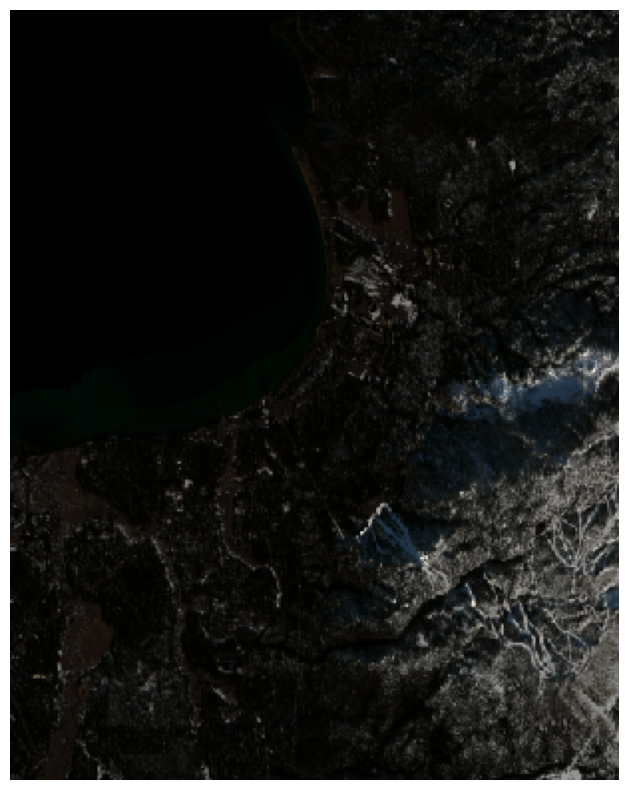

In [54]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

# Load the image (assuming you have already loaded the image1_xr dataset)
# image1_xr = rioxarray.open_rasterio('path_to_your_image')

# Select the Red, Green, and Blue bands (4, 3, 2 for Sentinel-2)
red_band = image1_xr.sel(band=4)
green_band = image1_xr.sel(band=3)
blue_band = image1_xr.sel(band=2)

# Stack the RGB bands into a single array for visualization
# Normalize the data to [0, 1] for better visualization (optional)
def normalize(array):
    """Normalize the array to [0, 1]"""
    return (array - array.min()) / (array.max() - array.min())

# Normalize each band
red = normalize(red_band)
green = normalize(green_band)
blue = normalize(blue_band)

# Stack the bands into an RGB image
rgb = np.stack([red, green, blue], axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')  # Remove axis for better visualization
plt.show()